In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

%matplotlib inline

from sklearn.decomposition import PCA, SparsePCA
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

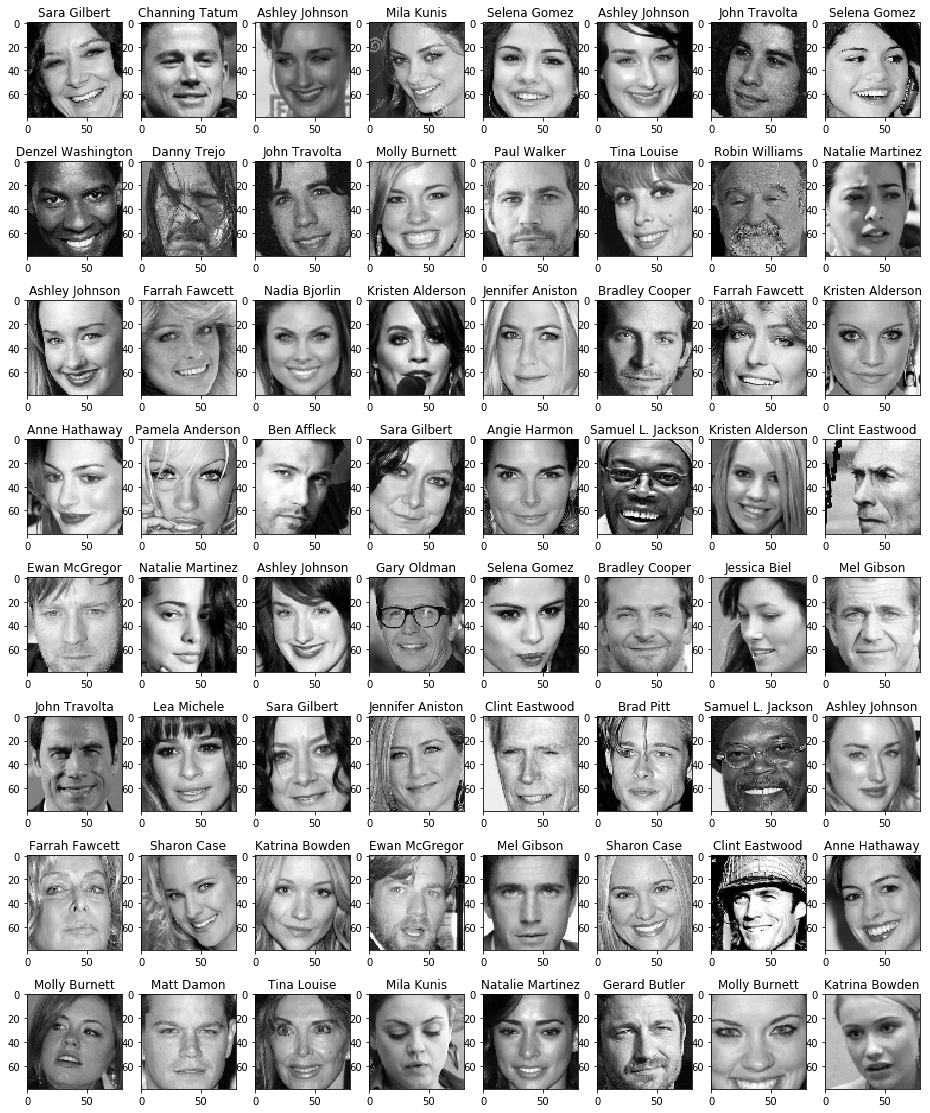

In [3]:
size = 80
shape =  2 * (size,)

X_train, y_train = shuffle(np.load('/Users/nikitos/P1/x_train.npy'), np.load('/Users/nikitos/P1/y_train.npy'))
X_test = np.load('/Users/nikitos/P1/test.npy')

width, height = 8, 8

plt.figure(figsize=(16, 20))
for n, (image, name) in enumerate(zip(X_train, y_train), 1):
    if n > width * height:
        break
        
    plt.subplot(height, width, n)
    plt.title(name)
    plt.imshow(image.reshape(shape), cmap='gray')

# Fixing validation

In [4]:
skf = StratifiedKFold(n_splits=8, random_state=42)

## Vanila kNN

In [6]:
neighbours = np.arange(1, 4, step=1)
scores = []
for n in tqdm_notebook(neighbours):
    knn = KNeighborsClassifier(n_neighbors=n, weights='distance', p=2)
    scores.append(
        cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy').mean()
    )

A Jupyter Widget

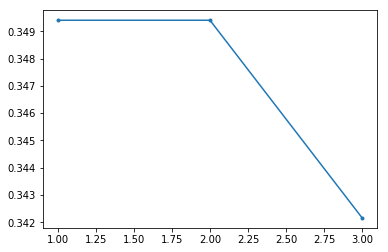

In [7]:
plt.plot(neighbours, scores, '.-')

Selecting p

In [8]:
cross_val_score(
    KNeighborsClassifier(n_neighbors=1, weights='uniform', p=2), 
    X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy'
).mean()

0.34940208907301296

In [9]:
cross_val_score(
    KNeighborsClassifier(n_neighbors=1, weights='uniform', p=3/2), 
    X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy'
).mean()

0.36535391708016002

In [10]:
cross_val_score(
    KNeighborsClassifier(n_neighbors=1, weights='distance', p=1), 
    X_train, y_train, cv=skf, n_jobs=-1, scoring='accuracy'
).mean()

0.37945725979588485

# PCA

In [11]:
pca = PCA(n_components=120)

In [12]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [14]:
cross_val_score(
    KNeighborsClassifier(n_neighbors=1, p=1), 
    X_train_pca, y_train, cv=skf, n_jobs=-1, scoring='accuracy'
).mean()

0.38656089485252498

# Image processing

Apparantely we don't anything (PCA, filters, etc) when we use HOG

In [5]:
from skimage import feature

In [6]:
def hog(X, orientations=9, pixels_per_cell=(6, 6), cells_per_block=(6, 6), block_norm='L1'):
    h = []
    for im in X.reshape(len(X), size, size):
        hogged = feature.hog(
            im, 
            orientations=orientations, 
            pixels_per_cell=pixels_per_cell, 
            cells_per_block=cells_per_block, 
            block_norm=block_norm,
        )
        h.append(hogged)
    print("%d features created" % len(h[0]))
    return np.array(h).reshape(len(X), len(h[0]))

In [7]:
X_train_hog = hog(X_train)
X_test_hog = hog(X_test)

20736 features created
20736 features created


In [18]:
cross_val_score(
    KNeighborsClassifier(n_neighbors=1, p=1), 
    X_train_hog, y_train, cv=skf, n_jobs=-1, scoring='accuracy'
).min()

0.61137440758293837

Fitting final classifier

In [8]:
knn = KNeighborsClassifier(n_neighbors=1, p=1)
knn.fit(X_train_hog, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')

Making submission

In [9]:
pd.DataFrame({
    'Id': 1 + np.arange(len(X_test)),
    'Name': knn.predict(X_test_hog),
}).to_csv('./P1.csv', index=False)

# Error analysis

In [22]:
from sklearn.model_selection import train_test_split

In [40]:
train_indeces, test_indeces = train_test_split(np.arange(len(X_train)), random_state=42, test_size=0.2)

In [42]:
knn.fit(X_train_hog[train_indeces], y_train[train_indeces])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')

In [44]:
predictions = knn.predict(X_train_hog[test_indeces])
answers = y_train[test_indeces]

In [50]:
errors = predictions != answers
print('Accuracy:', 1 - errors.mean())

Accuracy: 0.642441860465


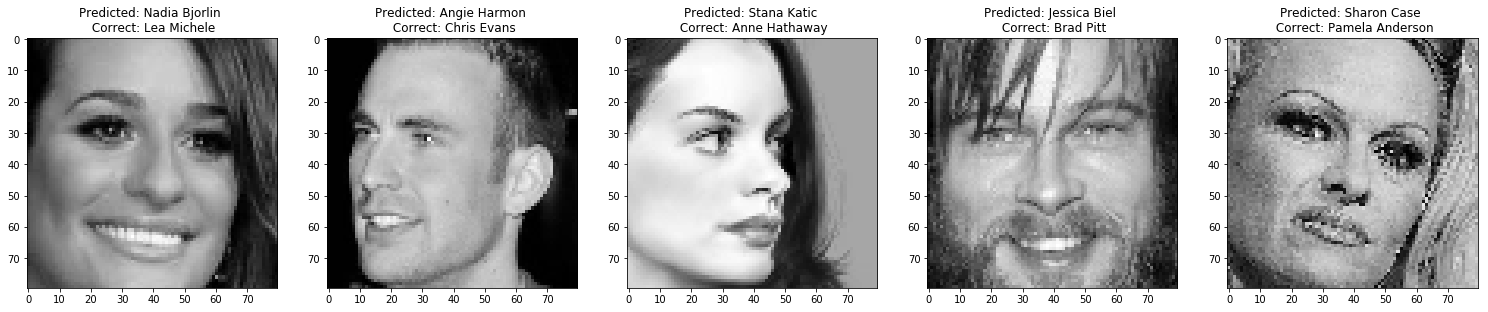

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(26, 15))

for i, pic in enumerate(np.random.choice(np.arange(errors.sum()), 5, replace=False)):
    axes[i].imshow(X_train[test_indeces][errors][pic].reshape(80, 80), cmap='gray')
    axes[i].set_title('Predicted: %s \n Correct: %s' % (predictions[errors][pic], answers[errors][pic]))